In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM,GRU

In [2]:
df = pd.read_csv('./data.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.drop(['new_confirmed_cases', 'new_deaths'], axis=1)
df.head()

,NO2,CO,PM25,OZONE,PM10,NO,7_day_avg_new_cases,7_day_avg_new_deaths
Date,,,,,,,,
2020-01-26,0.020,0.493,47.3,0.040,50.5,0.005,0.0,0.0
2020-01-27,0.042,0.822,24.6,0.041,40.8,0.071,0.0,0.0
2020-01-28,0.042,0.737,14.9,0.042,27.8,0.083,0.0,0.0
2020-01-29,0.031,0.732,11.0,0.042,44.7,0.037,0.0,0.0
2020-01-30,0.043,1.046,16.2,0.038,42.0,0.094,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 267 entries, 2020-01-26 to 2020-10-18
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NO2                   267 non-null    float64
 1   CO                    267 non-null    float64
 2   PM25                  267 non-null    float64
 3   OZONE                 267 non-null    float64
 4   PM10                  267 non-null    float64
 5   NO                    267 non-null    float64
 6   7_day_avg_new_cases   267 non-null    float64
 7   7_day_avg_new_deaths  267 non-null    float64
dtypes: float64(8)
memory usage: 18.8 KB


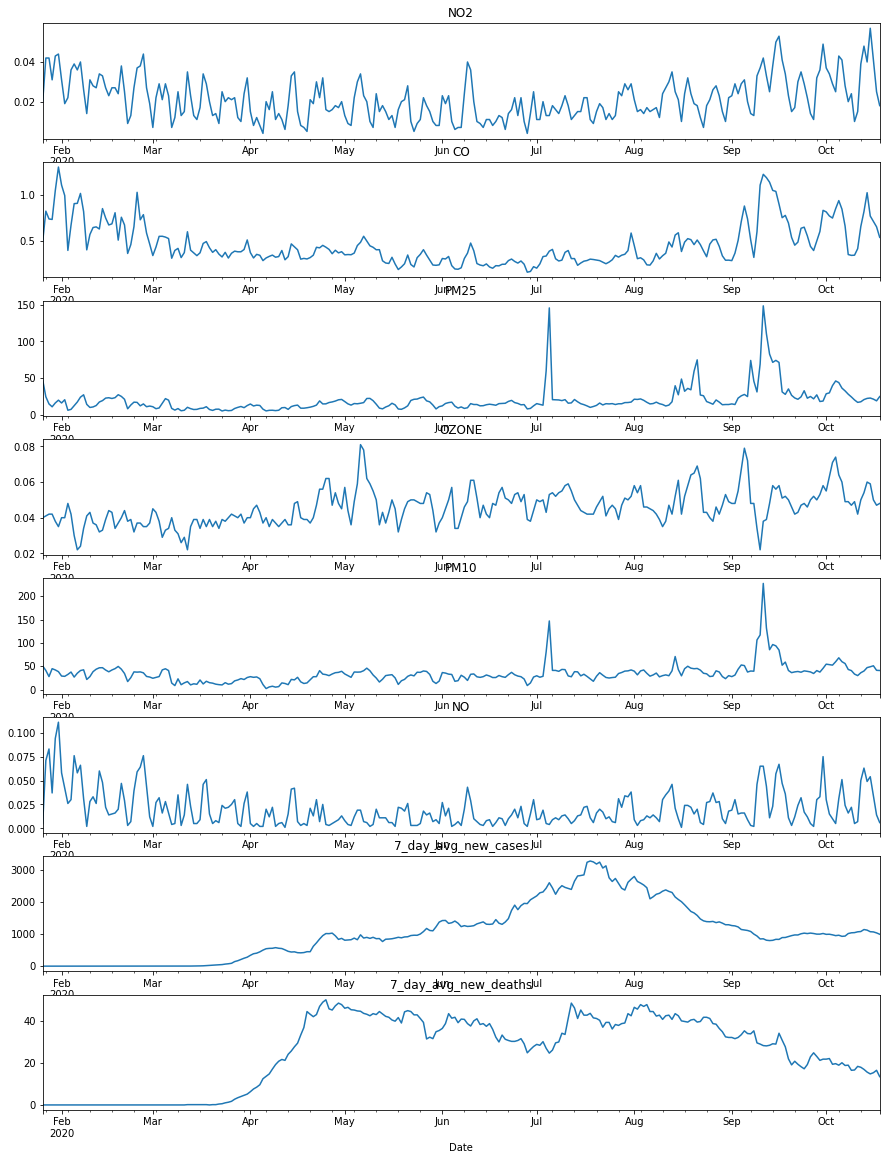

In [4]:
fig,ax = plt.subplots(8,1,figsize=(15,20))
for i,column in enumerate([col for col in df.columns]):
    df[column].plot(ax=ax[i])
    ax[i].set_title(column)

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
values = df.values
values = values.astype('float32')

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
reframed.drop(reframed.columns[[-3,-4,-5,-6,-7,-8]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var7(t),var8(t)
1,0.301887,0.292832,0.293912,0.305085,0.214920,0.036364,0.0,0.0,0.0,0.0
2,0.716981,0.580420,0.135059,0.322034,0.171847,0.636364,0.0,0.0,0.0,0.0
3,0.716981,0.506119,0.067180,0.338983,0.114121,0.745454,0.0,0.0,0.0,0.0
4,0.509434,0.501748,0.039888,0.338983,0.189165,0.327273,0.0,0.0,0.0,0.0
5,0.735849,0.776224,0.076277,0.271186,0.177176,0.845455,0.0,0.0,0.0,0.0


In [8]:
values = reframed.values
n_train = int(len(df)*.8)
train = values[:n_train]
test = values[n_train:]
trainX,trainY = train[:,:-2],train[:,-2:]
testX,testY = test[:,:-2],test[:,-2:]
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(213, 8) (213, 2) (53, 8) (53, 2)


In [9]:
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])
print(trainX.shape)
print(testX.shape)

(213, 1, 8)
(53, 1, 8)


In [10]:
stop_noimprovement = EarlyStopping(patience=20)
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]), dropout=0.2))
# model.add(LSTM(50, activation='relu', dropout=0.5))
model.add(Dense(2))
model.compile(loss="mse",optimizer="adam")

In [11]:
history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=2,callbacks=[stop_noimprovement],shuffle=False)

Train on 213 samples, validate on 53 samples
Epoch 1/100
213/213 - 3s - loss: 0.3252 - val_loss: 0.1852
Epoch 2/100
213/213 - 0s - loss: 0.3032 - val_loss: 0.1636
Epoch 3/100
213/213 - 0s - loss: 0.2816 - val_loss: 0.1431
Epoch 4/100
213/213 - 0s - loss: 0.2622 - val_loss: 0.1234
Epoch 5/100
213/213 - 0s - loss: 0.2401 - val_loss: 0.1045
Epoch 6/100
213/213 - 0s - loss: 0.2219 - val_loss: 0.0861
Epoch 7/100
213/213 - 0s - loss: 0.2023 - val_loss: 0.0687
Epoch 8/100
213/213 - 0s - loss: 0.1827 - val_loss: 0.0528
Epoch 9/100
213/213 - 0s - loss: 0.1611 - val_loss: 0.0389
Epoch 10/100
213/213 - 0s - loss: 0.1421 - val_loss: 0.0278
Epoch 11/100
213/213 - 0s - loss: 0.1249 - val_loss: 0.0201
Epoch 12/100
213/213 - 0s - loss: 0.1092 - val_loss: 0.0159
Epoch 13/100
213/213 - 0s - loss: 0.0969 - val_loss: 0.0152
Epoch 14/100
213/213 - 0s - loss: 0.0900 - val_loss: 0.0171
Epoch 15/100
213/213 - 0s - loss: 0.0844 - val_loss: 0.0207
Epoch 16/100
213/213 - 0s - loss: 0.0749 - val_loss: 0.0249
Epoc

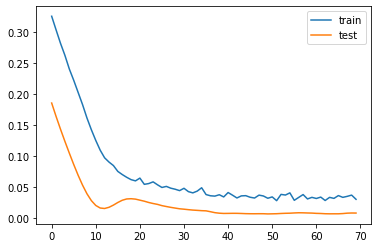

In [12]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [13]:
predicted = model.predict(testX)
testXRe = testX.reshape(testX.shape[0],testX.shape[2])
predicted = np.concatenate((testXRe[:,:-2], predicted),axis=1)[:,:8]
predicted = scaler.inverse_transform(predicted)
forecast_df = pd.DataFrame(predicted, columns=df.columns)

In [14]:
testY = test[:,-2:]
testY = testY.reshape(len(testY),2)
testY = np.concatenate((testXRe[:,:-2], testY),axis=1)
testY = scaler.inverse_transform(testY)
true_vals_df = pd.DataFrame(testY, columns=df.columns)

In [15]:
forecast_df.head()

,NO2,CO,PM25,OZONE,PM10,NO,7_day_avg_new_cases,7_day_avg_new_deaths
0,0.026,0.509,14.500000,0.038,28.700001,0.037,1379.385254,33.547157
1,0.028,0.516,20.299999,0.046,40.099998,0.027,1403.790771,35.476242
2,0.023,0.440,17.400000,0.042,37.700001,0.028,1384.007690,33.552471
3,0.015,0.336,13.800000,0.047,27.799999,0.010,1323.720459,32.544468
4,0.010,0.288,14.100000,0.053,23.299999,0.005,1298.274170,31.788725


In [16]:
true_vals_df.head()

,NO2,CO,PM25,OZONE,PM10,NO,7_day_avg_new_cases,7_day_avg_new_deaths
0,0.026,0.509,14.500000,0.038,28.700001,0.037,1359.142822,38.285713
1,0.028,0.516,20.299999,0.046,40.099998,0.027,1382.285767,36.285713
2,0.023,0.440,17.400000,0.042,37.700001,0.028,1343.285767,34.714287
3,0.015,0.336,13.800000,0.047,27.799999,0.010,1293.714233,32.285713
4,0.010,0.288,14.100000,0.053,23.299999,0.005,1293.142822,32.000000


In [17]:
new_cases_rmse = np.sqrt(mean_squared_error(testY[:,-2],predicted[:,-2]))
new_cases_rmse

159.9371

In [18]:
new_deaths_rmse = np.sqrt(mean_squared_error(testY[:,-1],predicted[:,-1]))
new_deaths_rmse

5.744774

In [19]:
print(new_cases_rmse/(true_vals_df['7_day_avg_new_cases'].max() - true_vals_df['7_day_avg_new_cases'].min()))
print(new_deaths_rmse/(true_vals_df['7_day_avg_new_deaths'].max() - true_vals_df['7_day_avg_new_deaths'].min()))

0.27420026
0.2311116
